### Importar bibliotecas

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Configurações de visualização para os gráficos
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.size'] = 12

In [100]:
# Configuração para exibir todas as colunas do DataFrame
display_max_columns = None
pd.set_option('display.max_columns', display_max_columns)

### Carregar os dados

In [101]:
# Carregando o dataset
caminho_arquivo = "C:\\Users\\Administrador\\Documents\\GitHub\\TJGO_CienciaDeDados\\microdados_censo_escolar_2024\\dados\\microdados_ed_basica_2024_tratado.csv"

colunas_escolhidas = ['CO_ENTIDADE', 'NO_ENTIDADE', 'NO_REGIAO', 'CO_REGIAO', 'NO_UF', 'SG_UF', 'CO_UF', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO','TP_SITUACAO_FUNCIONAMENTO', 'QT_MAT_BAS', 'QT_MAT_MED', 'IN_INTERNET', 'IN_BANDA_LARGA', 'IN_INTERNET_ALUNOS', 'IN_ACESSO_INTERNET_COMPUTADOR', 'TP_REDE_LOCAL', 'IN_LABORATORIO_INFORMATICA', 'QT_DESKTOP_ALUNO', 'QT_COMP_PORTATIL_ALUNO', 'QT_TABLET_ALUNO']

try:
    df_completa = pd.read_csv(caminho_arquivo, sep=';', encoding='latin-1', low_memory=False)
    df = pd.read_csv(caminho_arquivo, sep=';', encoding='latin-1', usecols=colunas_escolhidas, low_memory=False)
    print("Dados carregados com sucesso!")
    print(f"O dataset tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
except FileNotFoundError:
    print(f"Erro: O arquivo não foi encontrado no caminho especificado. Verifique o caminho: {caminho_arquivo}")

Dados carregados com sucesso!
O dataset tem 215545 linhas e 21 colunas.


In [102]:
display(df)

,CO_ENTIDADE,NO_ENTIDADE,NO_REGIAO,CO_REGIAO,NO_UF,SG_UF,CO_UF,TP_DEPENDENCIA,TP_LOCALIZACAO,TP_SITUACAO_FUNCIONAMENTO,QT_MAT_BAS,QT_MAT_MED,IN_INTERNET,IN_BANDA_LARGA,IN_INTERNET_ALUNOS,IN_ACESSO_INTERNET_COMPUTADOR,TP_REDE_LOCAL,IN_LABORATORIO_INFORMATICA,QT_DESKTOP_ALUNO,QT_COMP_PORTATIL_ALUNO,QT_TABLET_ALUNO
0,11022558,EIEEF HAP BITT TUPARI,Norte,1,Rondônia,RO,11,Estadual,Rural,Em Atividade,4.0,0.0,1.0,0.0,0.0,0.0,Não informado,0.0,0.0,1.0,0.0
1,11024275,CEEJA LUIZ VAZ DE CAMOES,Norte,1,Rondônia,RO,11,Estadual,Urbana,Em Atividade,131.0,0.0,1.0,1.0,1.0,1.0,A cabo e sem fio (wireless),1.0,19.0,4.0,0.0
2,11024291,EMMEF 7 DE SETEMBRO,Norte,1,Rondônia,RO,11,Municipal,Rural,Paralisada,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,11024666,EMEIEF BOA ESPERANCA,Norte,1,Rondônia,RO,11,Municipal,Rural,Em Atividade,169.0,0.0,1.0,0.0,0.0,0.0,A cabo,0.0,0.0,0.0,0.0
4,11024682,EEEFM EURIDICE LOPES PEDROSO,Norte,1,Rondônia,RO,11,Estadual,Urbana,Em Atividade,598.0,361.0,1.0,1.0,1.0,1.0,A cabo e sem fio (wireless),1.0,19.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215540,53084020,ESC PEQUENO ENCANTO,Centro-Oeste,5,Distrito Federal,DF,53,Privada,Urbana,Em Atividade,123.0,0.0,1.0,1.0,1.0,1.0,A cabo e sem fio (wireless),1.0,20.0,0.0,0.0
215541,53084039,SOCIEDADE ANCHIETA DE EDUCACAO INTEGRAL LTDA,Centro-Oeste,5,Distrito Federal,DF,53,Privada,Urbana,Em Atividade,382.0,0.0,1.0,1.0,1.0,1.0,A cabo e sem fio (wireless),1.0,20.0,10.0,1.0
215542,53084055,COL MAPA,Centro-Oeste,5,Distrito Federal,DF,53,Privada,Urbana,Em Atividade,373.0,61.0,1.0,1.0,1.0,1.0,A cabo,1.0,20.0,2.0,0.0
215543,53085000,COBIAN - COL BIANGULO,Centro-Oeste,5,Distrito Federal,DF,53,Privada,Urbana,Em Atividade,424.0,0.0,1.0,1.0,1.0,1.0,A cabo e sem fio (wireless),1.0,20.0,1.0,1.0


### Limpar os dados

In [103]:
# Tratamento de valores ausentes nas colunas de quantidade
colunas_qt = [col for col in df.columns if col.startswith('QT_')]
df[colunas_qt] = df[colunas_qt].fillna(0)

# Filtro original para escolas ativas
df_tratado = df[df['TP_SITUACAO_FUNCIONAMENTO'] == 'Em Atividade'].copy()
print(f"Número de escolas ativas: {df_tratado.shape[0]}")

Número de escolas ativas: 181065


In [104]:
# Manter apenas escolas que oferecem Ensino Médio (têm matrículas > 0)
df_ensino_medio = df_tratado[df_tratado['QT_MAT_MED'] > 0].copy()

print(f"Dataset filtrado para {len(df_ensino_medio)} escolas que oferecem Ensino Médio.")

Dataset filtrado para 29993 escolas que oferecem Ensino Médio.


In [105]:
# Substituir '88888.0' por np.nan
df_ensino_medio['QT_DESKTOP_ALUNO'] = df_ensino_medio['QT_DESKTOP_ALUNO'].replace(88888.0, np.nan)
df_ensino_medio['QT_COMP_PORTATIL_ALUNO'] = df_ensino_medio['QT_COMP_PORTATIL_ALUNO'].replace(88888.0, np.nan)
df_ensino_medio['QT_TABLET_ALUNO'] = df_ensino_medio['QT_TABLET_ALUNO'].replace(88888.0, np.nan)

### Tratamento dos dados

In [106]:
# Se 'QT_MAT_BASICO_TOTAL' inclui fundamental + médio, calculamos a diferença.
df_ensino_medio['QT_MAT_BAS_MENOS_EM'] = df_ensino_medio['QT_MAT_BAS'] - df_ensino_medio['QT_MAT_MED']

# Verificação para garantir que não há valores negativos (caso os dados estejam inconsistentes)
df_ensino_medio['QT_MAT_BAS_MENOS_EM'] = df_ensino_medio['QT_MAT_BAS_MENOS_EM'].apply(lambda x: max(0, x))

In [107]:
# Pesos para o cálculo do índice ponderado, tentei implementar esses pesos mas confundiu minha análise em relação aos valores calculados, por isso deixei como 1.0
peso_em = 1.0 
peso_fund = 1.0 # Peso base

In [108]:
# Cálculo da matrícula ponderada matriculas de ensino medio dividido pelo restante do ensino básico
df_ensino_medio['MATRICULA_PONDERADA'] = (df_ensino_medio['QT_MAT_MED'] * peso_em) + \
                                        (df_ensino_medio['QT_MAT_BAS_MENOS_EM'] * peso_fund)

# Cálculo do total de dispositivos
df_ensino_medio['QT_TOTAL_DISPOSITIVOS'] = df_ensino_medio['QT_DESKTOP_ALUNO'] + df_ensino_medio['QT_COMP_PORTATIL_ALUNO'] + df_ensino_medio['QT_TABLET_ALUNO']

# Substitui valores zero por NaN para evitar divisão por zero
dispositivos = df_ensino_medio['QT_TOTAL_DISPOSITIVOS'].replace(0, np.nan)
df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'] = df_ensino_medio['MATRICULA_PONDERADA'] / dispositivos

# Se a matrícula ponderada for 0, o resultado deve ser 0, não NaN
df_ensino_medio.loc[df_ensino_medio['MATRICULA_PONDERADA'] == 0, 'INDICE_PONDERADO_ALUNO_DISP'] = 0

# Preenche os casos de divisão por zero (dispositivos=0 mas alunos>0) com infinito
df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'].fillna(np.inf, inplace=True)

C:\Users\Administrador\AppData\Local\Temp\ipykernel_16200\3472870663.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'].fillna(np.inf, inplace=True)


In [109]:
# Criando o índice categórico com base na nova métrica
def classificar_acesso(ratio):
    if ratio == np.inf: return 'Nenhum'
    if ratio > 100: return 'Crítico'
    if ratio > 50: return 'Baixo'
    if ratio > 25: return 'Adequado'
    return 'Ideal'

# Reutilizando sua função original
df_ensino_medio['INDICE_ACESSO'] = df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'].apply(classificar_acesso)

print("Amostra do DataFrame com a nova coluna de índice:")
display(df_ensino_medio[['NO_ENTIDADE', 'INDICE_PONDERADO_ALUNO_DISP', 'INDICE_ACESSO']])

Amostra do DataFrame com a nova coluna de índice:


,NO_ENTIDADE,INDICE_PONDERADO_ALUNO_DISP,INDICE_ACESSO
4,EEEFM EURIDICE LOPES PEDROSO,31.473684,Adequado
6,EEEMTI JUSCELINO KUBITSCHEK DE OLIVEIRA,14.680000,Ideal
13,COLEGIO TIRADENTES DA POLICIA MILITAR - CTPM XI,26.428571,Adequado
15,EIEEFM KON KOATT TUPARI,inf,Nenhum
17,EIEEFM BOATT GERAINNY,inf,Nenhum
...,...,...,...
215520,CED 01 DO RIACHO FUNDO II,192.800000,Crítico
215529,CED 310 DE SANTA MARIA,92.900000,Baixo
215537,COL COC BRAZLANDIA DF,20.250000,Ideal
215542,COL MAPA,16.954545,Ideal


In [110]:
# Correto: Usando colchetes simples para criar a máscara booleana
df_ensino_medio[df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'] < np.inf]['INDICE_PONDERADO_ALUNO_DISP'].max()

2413.0

In [111]:
df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'].min()

0.022222222222222223

### Análise Exploratória (EDA)

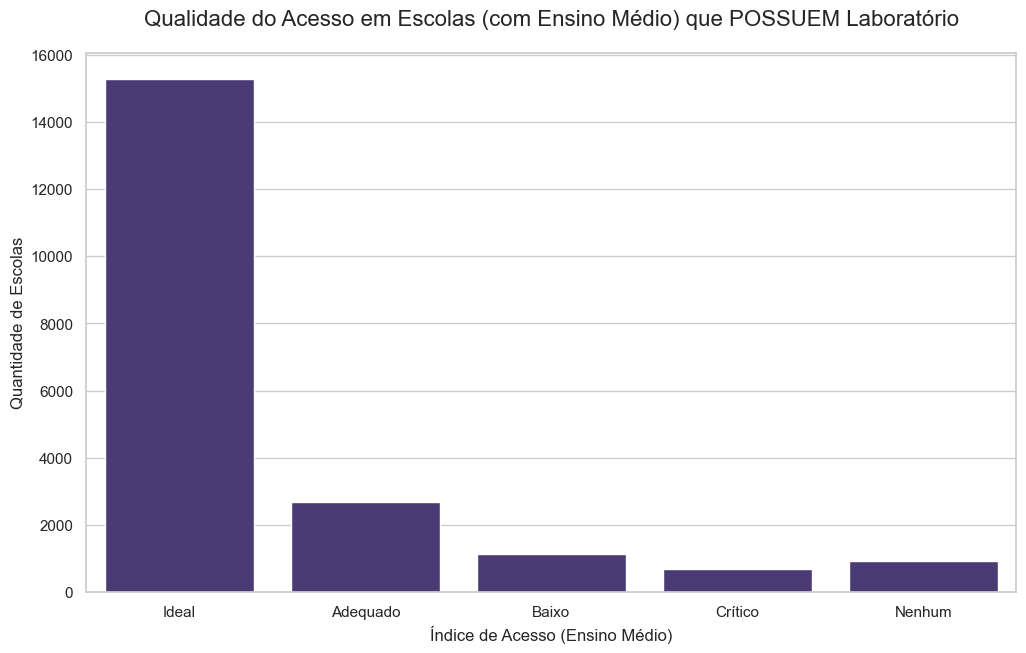

In [112]:
df_com_lab = df_ensino_medio[df_ensino_medio['IN_LABORATORIO_INFORMATICA'] == 1]

plt.figure()

sns.countplot(
    data=df_com_lab,
    x='INDICE_ACESSO',
    order=['Ideal', 'Adequado', 'Baixo', 'Crítico', 'Nenhum']
)

plt.title('Qualidade do Acesso em Escolas (com Ensino Médio) que POSSUEM Laboratório', fontsize=16, pad=20)
plt.xlabel('Índice de Acesso (Ensino Médio)')
plt.ylabel('Quantidade de Escolas')
plt.show()

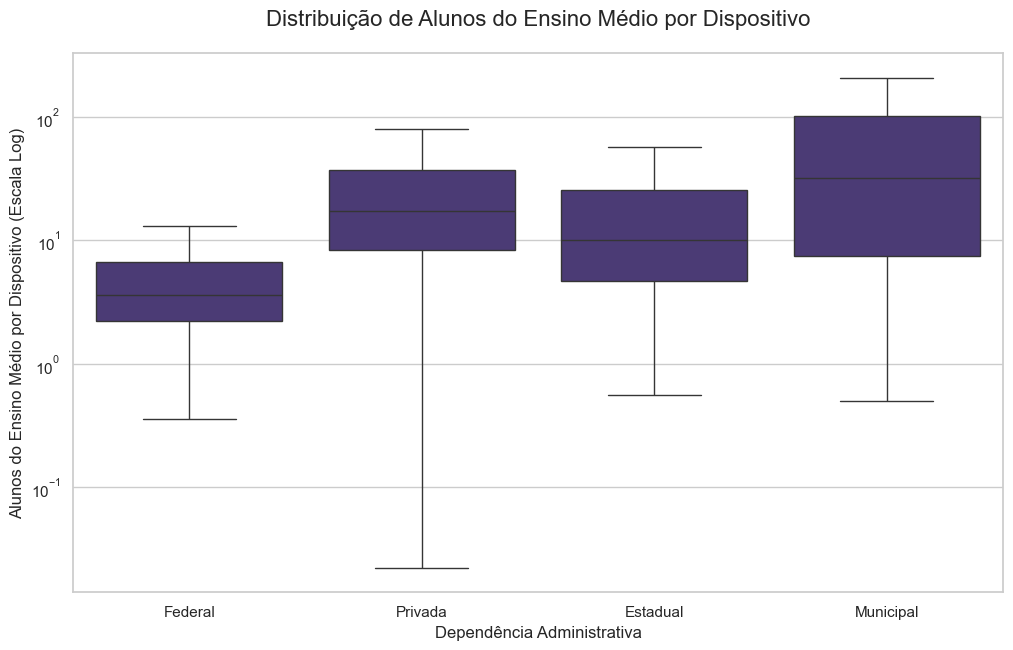

In [113]:

ordem_completa = ['Federal', 'Privada', 'Estadual', 'Municipal']

df_plot_dep_em = df_ensino_medio[df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'] != np.inf].copy()

categorias_presentes = df_plot_dep_em['TP_DEPENDENCIA'].unique()
ordem_segura = [cat for cat in ordem_completa if cat in categorias_presentes]

plt.figure()
sns.boxplot(
    data=df_plot_dep_em, 
    x='TP_DEPENDENCIA', 
    y='INDICE_PONDERADO_ALUNO_DISP',
    showfliers=False, 
    order=ordem_segura 
)

plt.title('Distribuição de Alunos do Ensino Médio por Dispositivo', fontsize=16, pad=20)
plt.xlabel('Dependência Administrativa')
plt.ylabel('Alunos do Ensino Médio por Dispositivo (Escala Log)')
plt.yscale('log')
plt.show()

Ranking de Desigualdade por UF...


C:\Users\Administrador\AppData\Local\Temp\ipykernel_16200\1451991648.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_por_uf.values, y=media_por_uf.index, palette="plasma", orient='h')


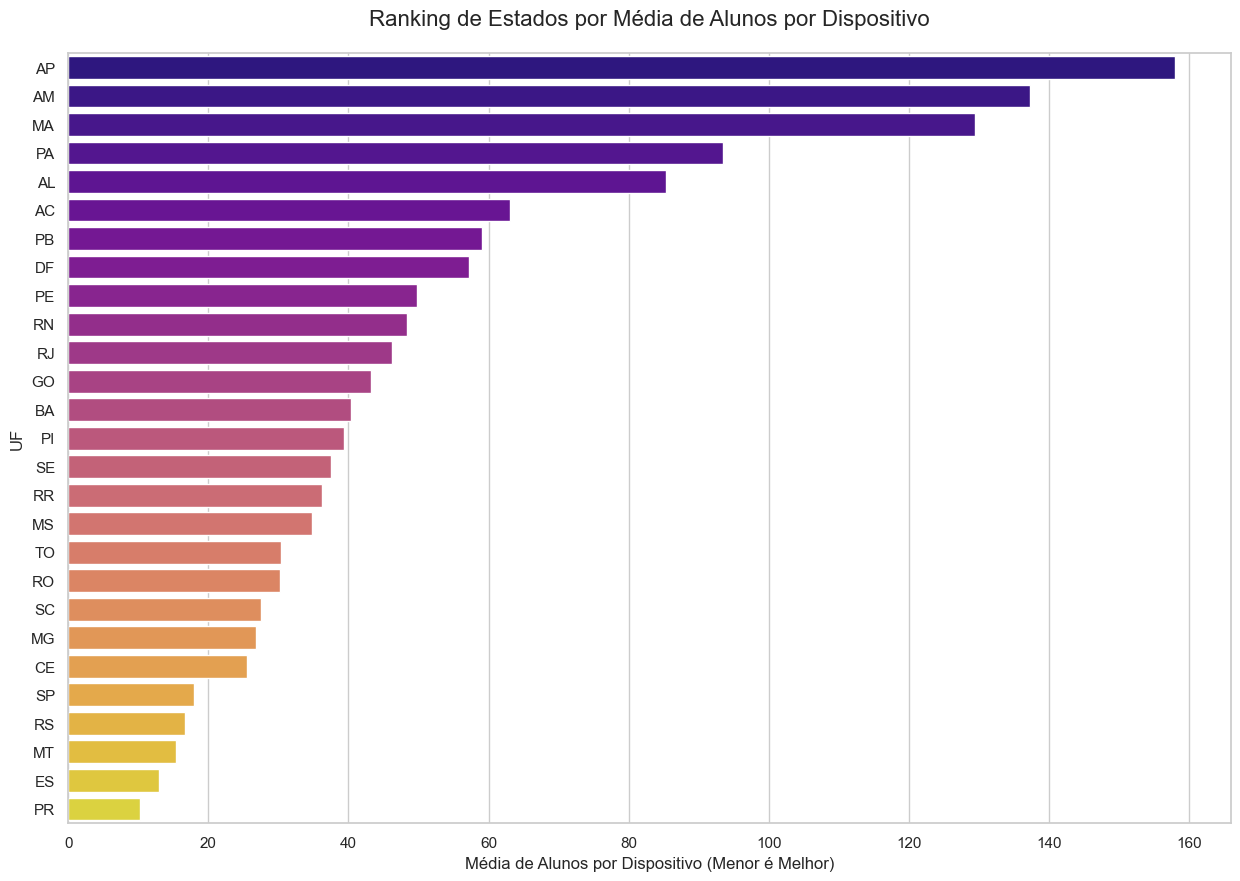

In [114]:
# --- Análise por Unidade Federativa (UF) ---

print("Ranking de Desigualdade por UF...")

# Calcular a média de alunos por dispositivo para cada estado
df_uf = df_ensino_medio[df_ensino_medio['INDICE_PONDERADO_ALUNO_DISP'] != np.inf].copy()
media_por_uf = df_uf.groupby('SG_UF')['INDICE_PONDERADO_ALUNO_DISP'].mean().sort_values(ascending=False)

# Criar o gráfico de barras
plt.figure(figsize=(15, 10))
sns.barplot(x=media_por_uf.values, y=media_por_uf.index, palette="plasma", orient='h')

plt.title('Ranking de Estados por Média de Alunos por Dispositivo', fontsize=16, pad=20)
plt.xlabel('Média de Alunos por Dispositivo (Menor é Melhor)')
plt.ylabel('UF')
plt.show()

 Análise cruzada por UF e Dependência...


C:\Users\Administrador\AppData\Local\Temp\ipykernel_16200\2167042970.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


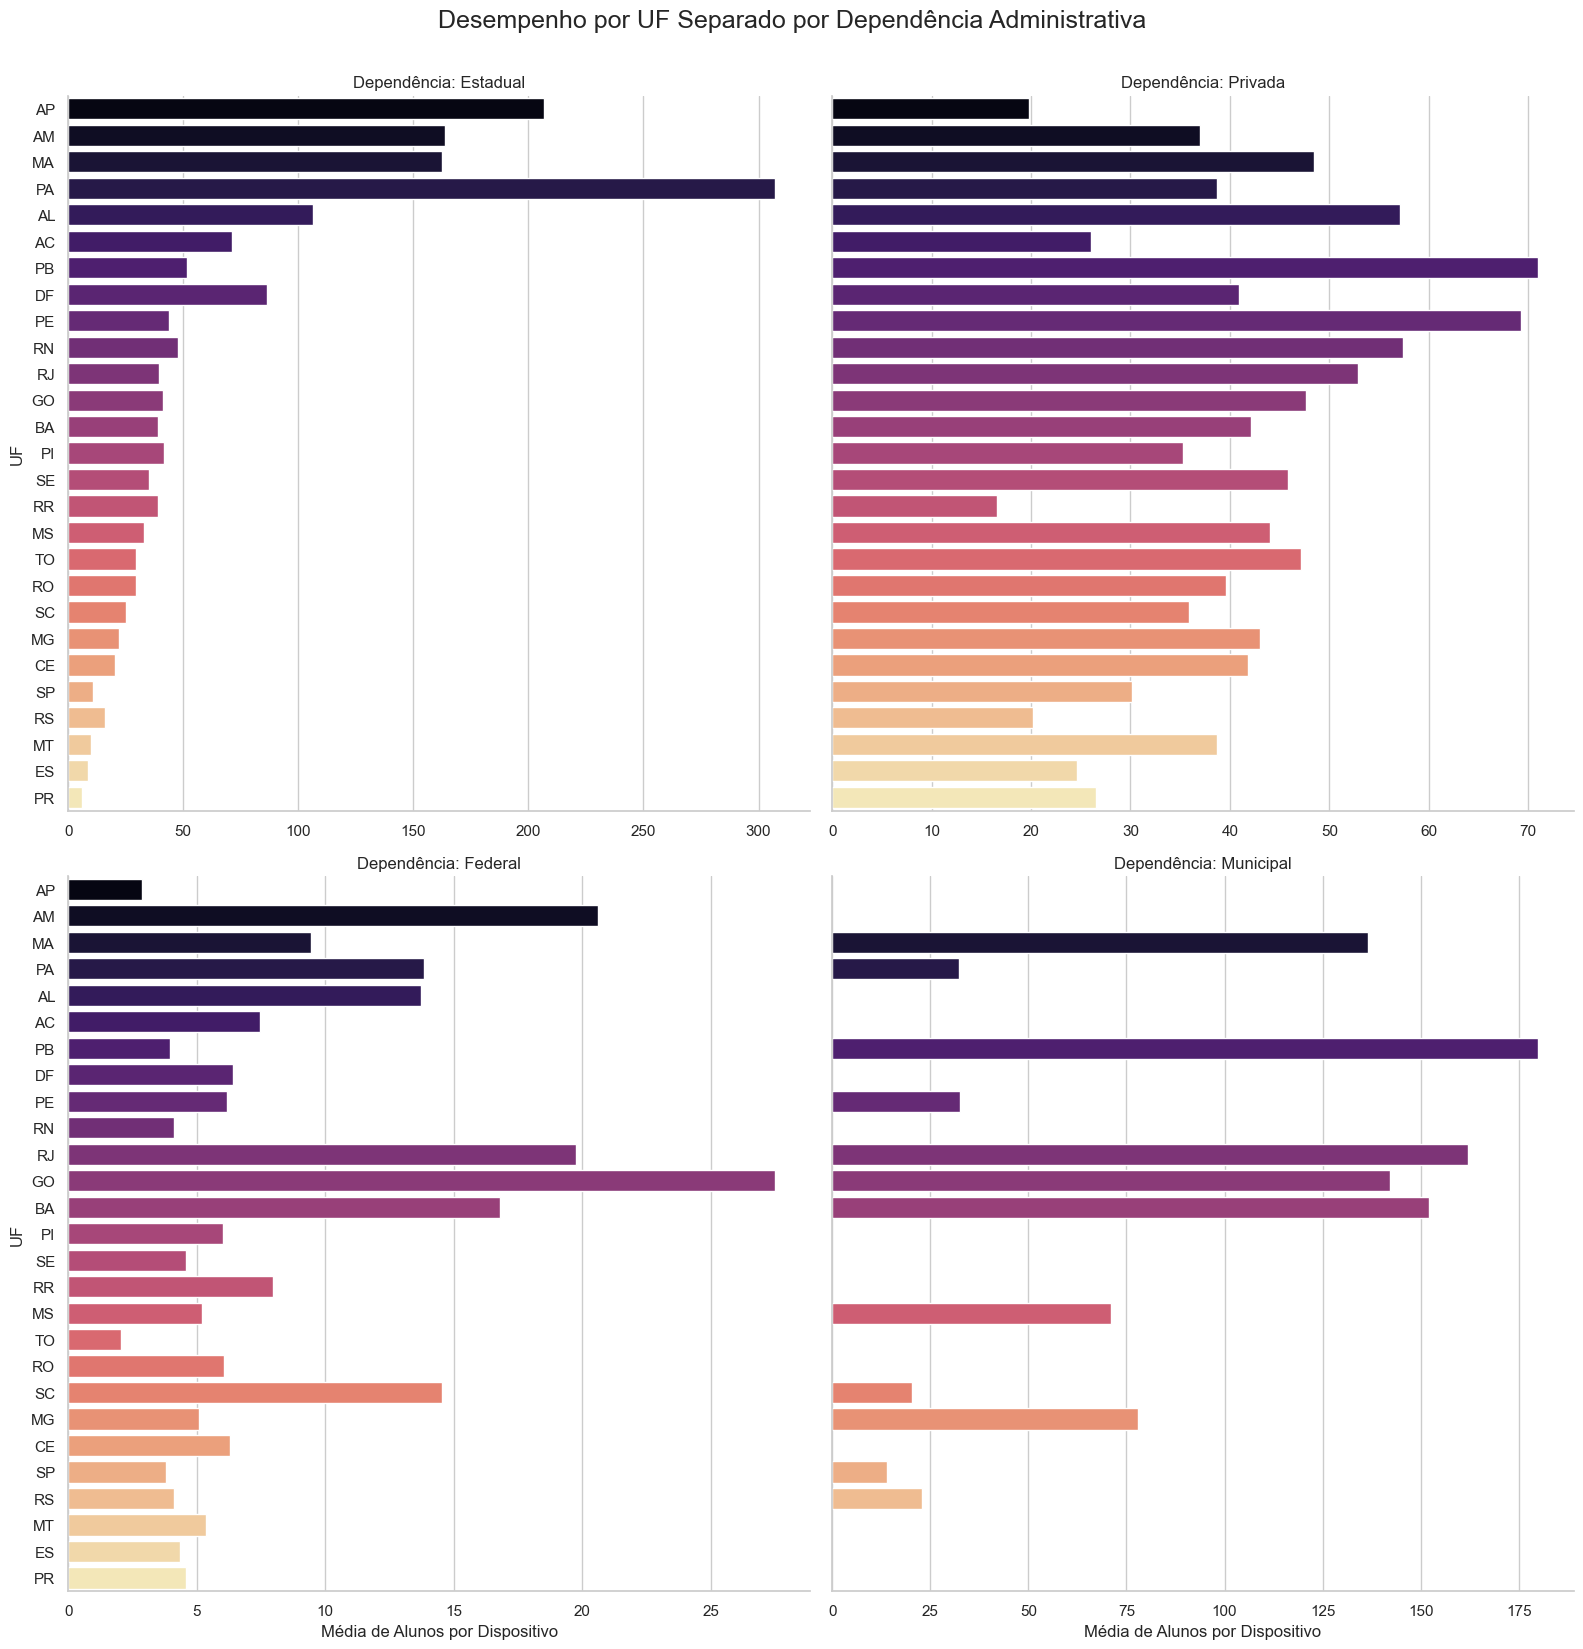

In [115]:
# --- Análise Cruzada: UF vs. Dependência Administrativa ---
print(" Análise cruzada por UF e Dependência...")

# Usamos o catplot para criar uma grade de gráficos (um para cada dependência)
g = sns.catplot(
    data=df_uf,
    x='INDICE_PONDERADO_ALUNO_DISP',
    y='SG_UF',
    col='TP_DEPENDENCIA',
    kind='bar',
    col_wrap=2, # Duas colunas de gráficos
    height=8,
    aspect=1,
    sharex=False, # Eixo X independente para cada gráfico
    order=media_por_uf.index, # Ordenar os estados pelo ranking geral
    estimator=np.mean,
    errorbar=None,
    palette='magma'
)

g.fig.suptitle('Desempenho por UF Separado por Dependência Administrativa', y=1.03, fontsize=18)
g.set_axis_labels('Média de Alunos por Dispositivo', 'UF')
g.set_titles("Dependência: {col_name}")
plt.show()

### Clusterização

In [116]:
features_cluster = [
    'QT_MAT_BAS',
    'INDICE_PONDERADO_ALUNO_DISP',
    'TP_DEPENDENCIA',
    'IN_BANDA_LARGA',
    'IN_LABORATORIO_INFORMATICA',
    'SG_UF'
]

# 2. Preparação do dataframe para o modelo
df_cluster = df_ensino_medio[features_cluster].copy()

In [117]:
df_cluster[df_cluster['INDICE_PONDERADO_ALUNO_DISP'] < np.inf]['INDICE_PONDERADO_ALUNO_DISP'].max()

2413.0

In [118]:
df_cluster[df_cluster['INDICE_PONDERADO_ALUNO_DISP'] < np.inf]['INDICE_PONDERADO_ALUNO_DISP'].min()

0.022222222222222223

In [119]:
df_cluster.dropna(inplace=True) # É melhor dropar NaNs antes de criar novas colunas

# Crie a feature binária para escolas sem dispositivos
df_cluster['IN_SEM_DISPOSITIVO'] = np.where(df_cluster['INDICE_PONDERADO_ALUNO_DISP'] == np.inf, 1, 0)

# Calcule a mediana APENAS dos valores finitos
mediana_indice = df_cluster.loc[df_cluster['INDICE_PONDERADO_ALUNO_DISP'] != np.inf, 'INDICE_PONDERADO_ALUNO_DISP'].median()

# Substitua o inf pela mediana
df_cluster['INDICE_PONDERADO_ALUNO_DISP'].replace([np.inf], mediana_indice, inplace=True)


# 5. One-Hot Encoding das features categóricas
df_cluster_encoded = pd.get_dummies(
    df_cluster,
    columns=['TP_DEPENDENCIA', 'SG_UF'],
    drop_first=True
)

# Escalar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_encoded)

# Construção e Treinamento do Modelo K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)

# Adicionar os resultados do cluster de volta ao dataframe
df_cluster_encoded['cluster'] = clusters

print("Clusters formados:")
print(df_cluster_encoded['cluster'].value_counts().sort_index())
print("\n" + "="*40 + "\n")

# 8. Avaliação do Modelo (seu código original aqui está perfeito)
silhouette = silhouette_score(X_scaled, kmeans.labels_)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans.labels_)

print(f"**Métricas de Avaliação do Modelo K-Means**")
print(f"-------------------------------------------")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

C:\Users\Administrador\AppData\Local\Temp\ipykernel_16200\2644735719.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cluster['INDICE_PONDERADO_ALUNO_DISP'].replace([np.inf], mediana_indice, inplace=True)


Clusters formados:
cluster
0    14463
1     3631
2      366
3    10670
Name: count, dtype: int64


**Métricas de Avaliação do Modelo K-Means**
-------------------------------------------
Silhouette Score: 0.0955
Davies-Bouldin Index: 3.0249
Calinski-Harabasz Index: 1059.5420


In [120]:
df_analise_final = df_ensino_medio.loc[df_cluster.index].copy()
df_analise_final['cluster'] = df_cluster_encoded['cluster']

# Calcular a média das features numéricas por cluster
resumo_numerico = df_analise_final.groupby('cluster')[['QT_MAT_BAS', 'INDICE_PONDERADO_ALUNO_DISP']].mean().round(2)

# Calcular a moda das features categóricas por cluster
resumo_categorico = df_analise_final.groupby('cluster')[['TP_DEPENDENCIA', 'TP_LOCALIZACAO']].agg(lambda x: x.mode()[0])

# Juntar os resumos para criar a tabela de perfis
resumo_final_clusters = pd.concat([resumo_numerico, resumo_categorico], axis=1)

print(resumo_final_clusters)


print("\n--- Análise de UF por Cluster (Exemplo com Cluster 0) ---")
cluster_exemplo = 0
uf_distribution = df_analise_final[df_analise_final['cluster'] == cluster_exemplo]['SG_UF'].value_counts().nlargest(5)
print(f"Top 5 UFs mais comuns no Cluster {cluster_exemplo}:\n{uf_distribution}")

         QT_MAT_BAS  INDICE_PONDERADO_ALUNO_DISP TP_DEPENDENCIA TP_LOCALIZACAO
cluster                                                                       
0            532.24                          inf       Estadual         Urbana
1            475.60                          inf       Estadual         Urbana
2            353.28                          inf       Estadual         Urbana
3            583.94                          inf       Estadual         Urbana

--- Análise de UF por Cluster (Exemplo com Cluster 0) ---
Top 5 UFs mais comuns no Cluster 0:
SG_UF
MG    3344
PR    2095
RS    1566
PE    1118
GO    1088
Name: count, dtype: int64


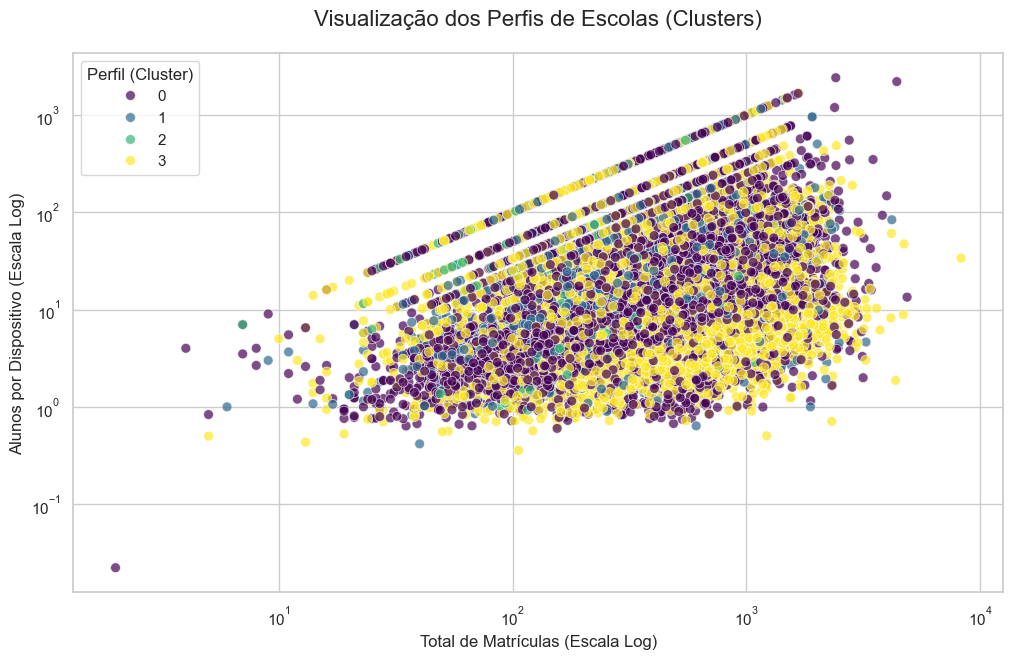

In [121]:
plt.figure()

sample_df = df_analise_final.sample(n=min(50000, len(df_analise_final)), random_state=42)

sns.scatterplot(data=sample_df, x='QT_MAT_BAS', y='INDICE_PONDERADO_ALUNO_DISP', hue='cluster', palette='viridis', alpha=0.7, s=50)
plt.title('Visualização dos Perfis de Escolas (Clusters)', fontsize=16, pad=20)
plt.xlabel('Total de Matrículas (Escala Log)')
plt.ylabel('Alunos por Dispositivo (Escala Log)')
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Perfil (Cluster)')
plt.show()

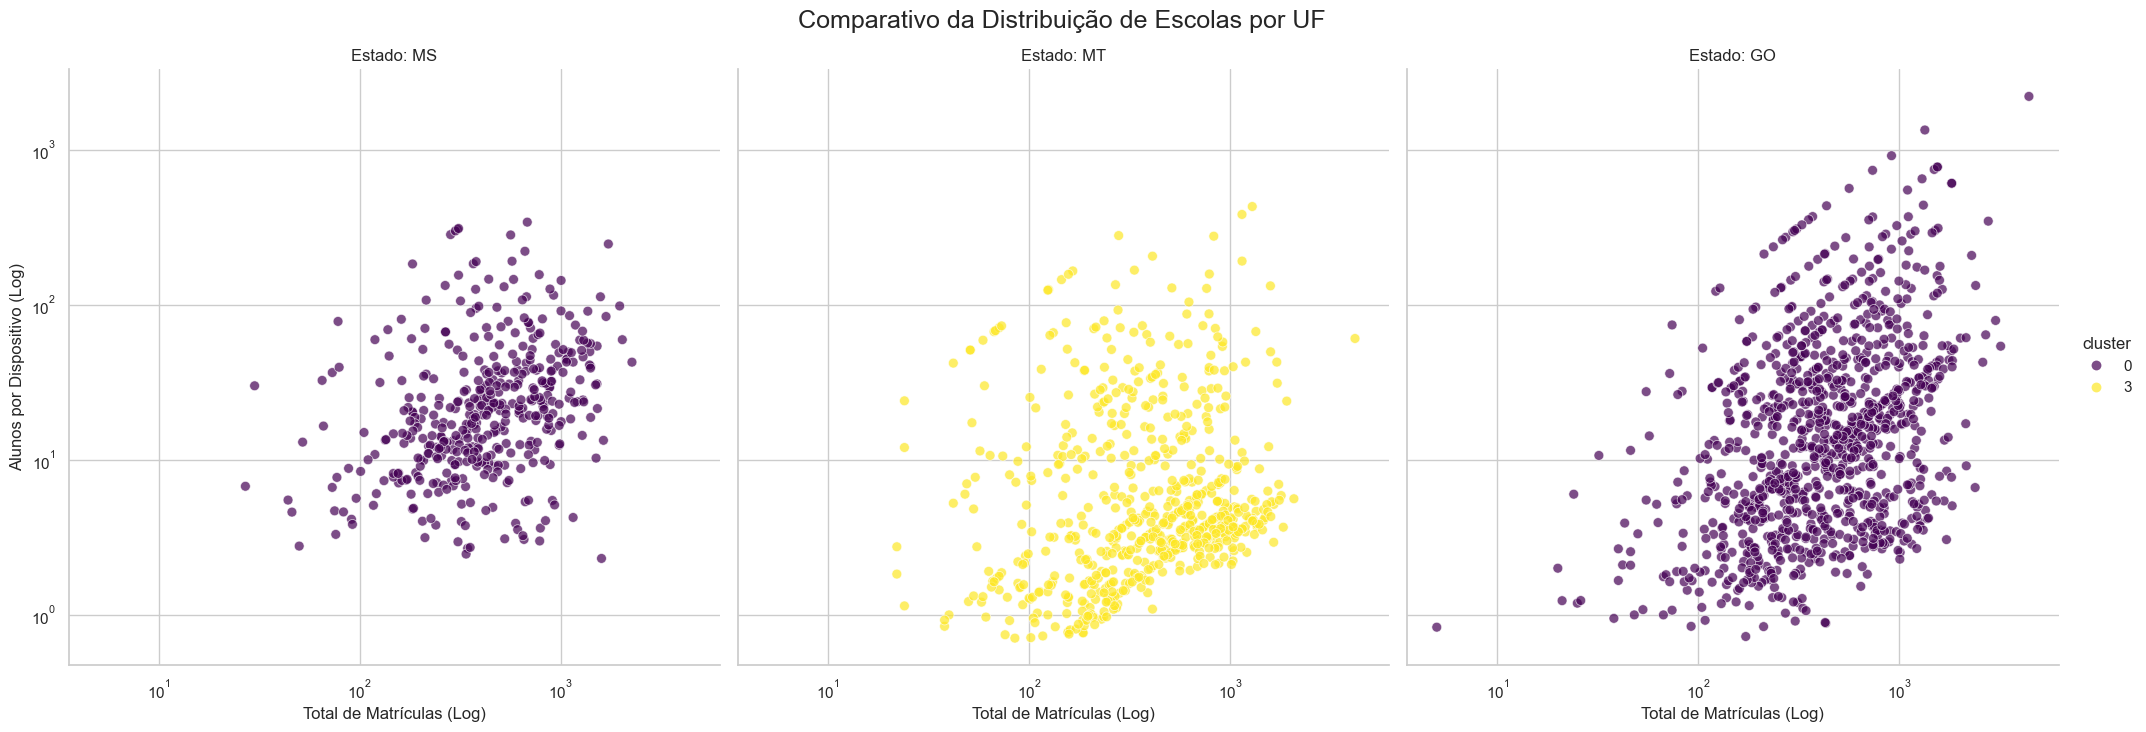

In [122]:
# --- Visualização Comparativa entre Estados ---

ufs_comparar = ['MT', 'MS', 'GO']

df_comparativo = df_analise_final[df_analise_final['SG_UF'].isin(ufs_comparar)]

g = sns.relplot(
    data=df_comparativo,
    x='QT_MAT_BAS',
    y='INDICE_PONDERADO_ALUNO_DISP',
    hue='cluster',
    col='SG_UF',
    palette='viridis',
    height=7,
    aspect=1,
    s=50,
    alpha=0.7
)

g.fig.suptitle('Comparativo da Distribuição de Escolas por UF', y=1.03, fontsize=18)
g.set_axis_labels('Total de Matrículas (Log)', 'Alunos por Dispositivo (Log)')
g.set_titles("Estado: {col_name}")
g.set(xscale="log", yscale="log")
plt.show()

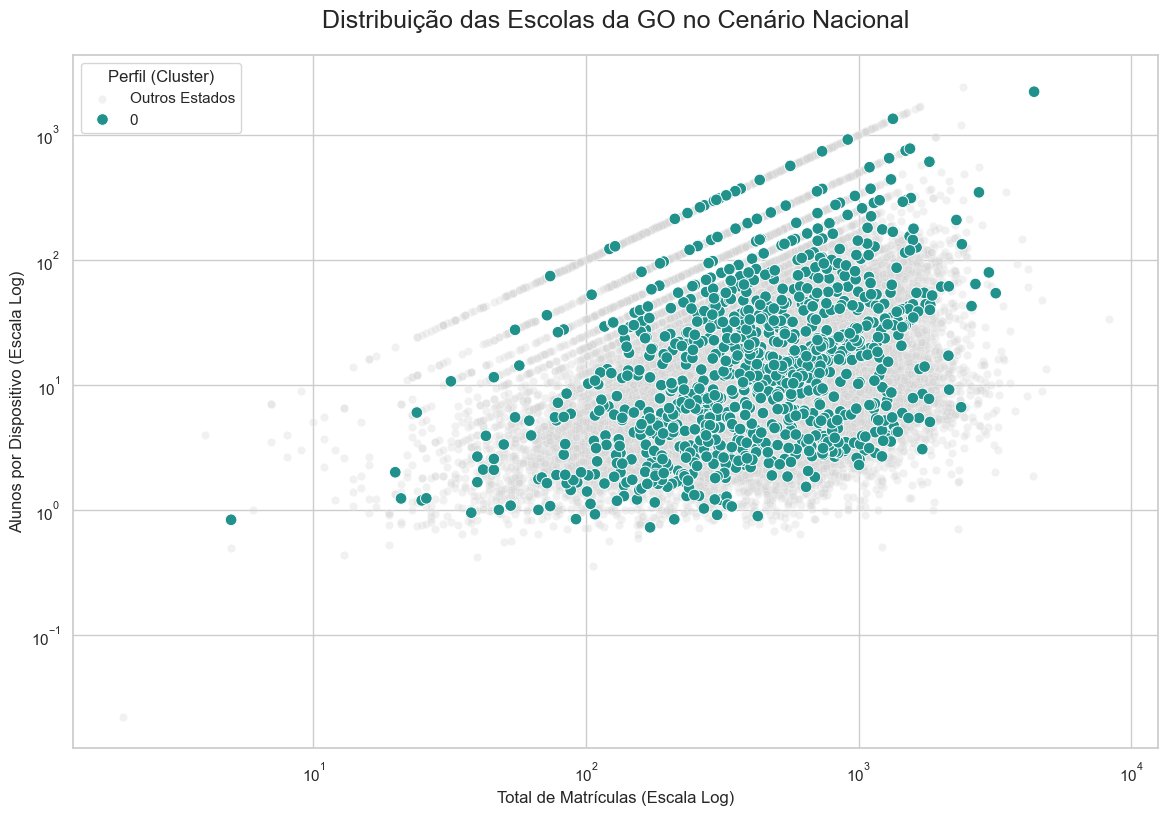

In [123]:
# --- Visualização com Foco em um Estado Específico ---

uf_foco = 'GO' 

plt.figure(figsize=(14, 9))

sns.scatterplot(
    data=sample_df, 
    x='QT_MAT_BAS', 
    y='INDICE_PONDERADO_ALUNO_DISP', 
    color='lightgray',
    alpha=0.3,
    label='Outros Estados'
)

df_foco = df_analise_final[df_analise_final['SG_UF'] == uf_foco]
sns.scatterplot(
    data=df_foco, 
    x='QT_MAT_BAS', 
    y='INDICE_PONDERADO_ALUNO_DISP', 
    hue='cluster', 
    palette='viridis',
    s=70, # Aumenta o tamanho dos pontos para destaque
    legend='full'
)

plt.title(f'Distribuição das Escolas da {uf_foco} no Cenário Nacional', fontsize=18, pad=20)
plt.xlabel('Total de Matrículas (Escala Log)')
plt.ylabel('Alunos por Dispositivo (Escala Log)')
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Perfil (Cluster)')
plt.savefig("cluster_GO.png")
plt.show()